In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
arr_hub = np.loadtxt('Hz_all.dat')
z_data, H_obs, sigma_H = arr_hub[:, 0], arr_hub[:, 1], arr_hub[:, 2]


H0 = 70  
Omega_m = 0.3

def hubble_cpl(z, w0, wa):
    Omega_L = 1 - Omega_m
    E = np.sqrt(Omega_m * (1 + z)**3 + Omega_L * (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z)))
    return H0 * E

def log_likelihood(params):
    w0, wa = params  
    H_model = hubble_cpl(z_data, w0, wa)
    return -0.5 * np.sum(((H_obs - H_model) / sigma_H) ** 2)

In [4]:
def mutate(parents, fitness_function):
    if len(parents) == 0:
        return []
    
    scores = np.array([fitness_function(ind) for ind in parents])
    idx = scores > np.percentile(scores, 50)  # Selección de los mejores individuos
    parents = np.array(parents)[idx]
    scores = scores[idx]
    
    if len(parents) == 0:
        return []
    
    children = np.array([random.choice(parents) for _ in range(len(parents))])
    children = children + np.random.uniform(-0.05, 0.05, size=children.shape)  # Mutación
    return children.tolist()

# Algoritmo genético
def GA(popsize=100, generations=200, bounds=[(-1.5, 0.5), (-1.0, 1.0)]):
    population = np.array([[random.uniform(bounds[0][0], bounds[0][1]), 
                            random.uniform(bounds[1][0], bounds[1][1])] for _ in range(popsize)])
    
    if len(population) == 0:
        raise ValueError("La población inicial está vacía.")
    
    best_likelihoods = []
    best_parent = max(population, key=log_likelihood)
    best_fitness = log_likelihood(best_parent)
    
    for gen in range(generations):
        population = mutate(population, log_likelihood)
        
        if len(population) == 0:
            break
        
        curr_parent = max(population, key=log_likelihood)
        curr_fitness = log_likelihood(curr_parent)
        
        if curr_fitness > best_fitness:
            best_fitness = curr_fitness
            best_parent = curr_parent
        
        best_likelihoods.append(best_fitness)
        if gen % 10 == 0:
            print(f'Generación {gen+1} | Mejor w0={best_parent[0]:.3f}, wa={best_parent[1]:.3f}, Log-Likelihood={best_fitness:.3f}')
    
    print(f'Parámetros óptimos: w0={best_parent[0]:.3f}, wa={best_parent[1]:.3f}')
    return best_parent, best_likelihoods


Generación 1 | Mejor w0=-1.171, wa=0.506, Log-Likelihood=-7.115
Parámetros óptimos: w0=-1.171, wa=0.506


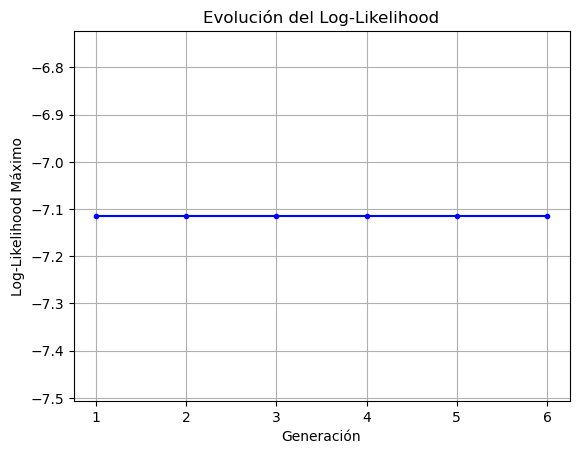

In [ ]:
# Ejecutar el algoritmo genético
try:
    (best_w0, best_wa), best_likelihoods = GA()
except ValueError as e:
    print(f"Error: {e}")
    best_w0, best_wa, best_likelihoods = None, None, []


if best_likelihoods:
    plt.plot(range(1, len(best_likelihoods) + 1), best_likelihoods, marker=".", linestyle="-", color="b")
    plt.xlabel("Generación")
    plt.ylabel("Log-Likelihood Máximo")
    plt.title("Evolución del Log-Likelihood")
    plt.grid()
    plt.show()



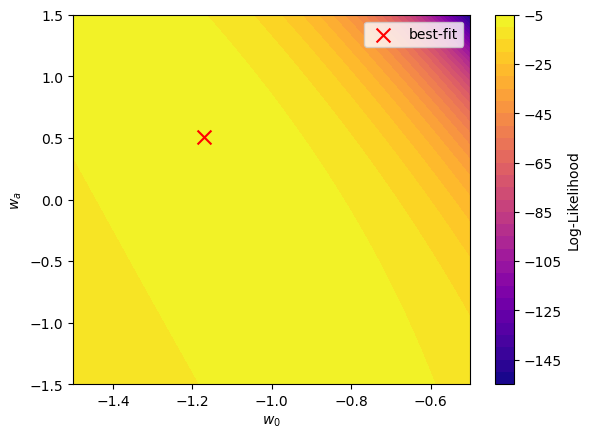

In [8]:
w0_vals = np.linspace(-1.5, -0.5, 50)
wa_vals = np.linspace(-1.5, 1.5, 50)
L_vals = np.array([[log_likelihood([w0, wa]) for wa in wa_vals] for w0 in w0_vals])

plt.contourf(w0_vals, wa_vals, L_vals.T, levels=30, cmap="plasma")
plt.colorbar(label="Log-Likelihood")
plt.scatter(best_w0, best_wa, color="red", marker="x", s=100, label="best-fit")
plt.xlabel("$w_0$")
plt.ylabel("$w_a$")
plt.legend()
plt.show()